/Users/saisowmithm/.pyenv/versions/3.12.4/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 26 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loaded best model for prediction
Analyzing MP3 file: /Users/saisowmithm/Downloads/Snoring /snoring-app/research/test_audio/snoring-331163.mp3
MP3 loaded successfully. Length: 361117 samples, Duration: 22.57 seconds
Split audio into 44 segments for analysis
Segment 1: Not Snoring (confidence: 0.9968)
Segment 2: Snoring (confidence: 0.7575)
Segment 3: Not Snoring (confidence: 0.5626)
Segment 4: Snoring (confidence: 0.7454)
Segment 5: Snoring (confidence: 0.7056)
MP3 loaded successfully. Length: 361117 samples, Duration: 22.57 seconds

Snoring Analysis:
Total segments analyzed: 44
Snoring segments: 39 (88.6%)
Snoring intervals: 1
  Interval 1: 1.5s - 20.5s (19.0s)


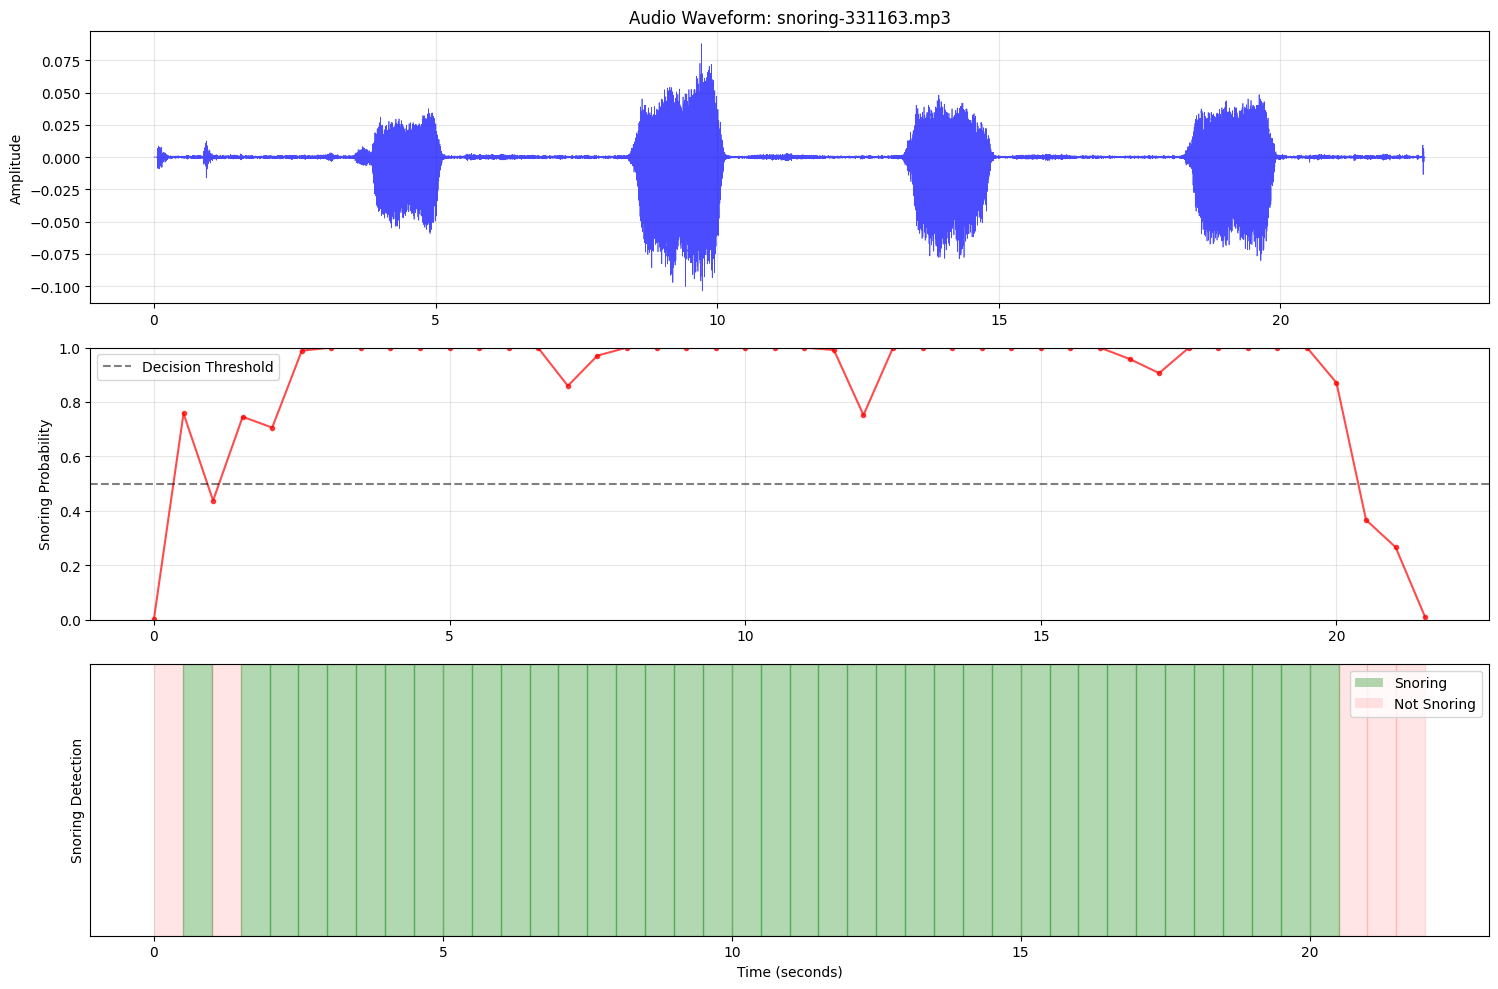


Overall Conclusion:
🔊 HIGH snoring activity detected!
Snoring present in 88.6% of the audio


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import io
from pydub import AudioSegment

def convert_mp3_to_wav(mp3_path, output_wav_path=None):
    """Convert MP3 file to WAV format using pydub"""
    try:
        # Load MP3 file
        audio = AudioSegment.from_file(mp3_path, format="mp3")
        
        # Convert to mono and set sample rate to 16kHz
        audio = audio.set_frame_rate(16000).set_channels(1)
        
        if output_wav_path:
            # Export to WAV file
            audio.export(output_wav_path, format="wav")
            print(f"MP3 converted to WAV: {output_wav_path}")
            return output_wav_path
        else:
            # Export to bytes buffer for in-memory processing
            wav_buffer = io.BytesIO()
            audio.export(wav_buffer, format="wav")
            wav_buffer.seek(0)
            return wav_buffer
            
    except Exception as e:
        print(f"Error converting MP3: {e}")
        return None

def load_mp3_as_tensor(mp3_path):
    """Load MP3 file and convert to TensorFlow tensor"""
    try:
        # Convert MP3 to WAV in memory
        wav_buffer = convert_mp3_to_wav(mp3_path)
        
        if wav_buffer is None:
            return None
            
        # Read the WAV data from buffer
        audio_binary = wav_buffer.read()
        
        # Decode WAV using TensorFlow
        wav, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1)
        wav = tf.squeeze(wav, axis=-1)
        
        print(f"MP3 loaded successfully. Length: {len(wav)} samples, Duration: {len(wav)/16000:.2f} seconds")
        return wav
        
    except Exception as e:
        print(f"Error loading MP3 as tensor: {e}")
        return None

def preprocess_mp3_for_prediction(mp3_path, model):
    """Preprocess MP3 file and make prediction"""
    # Load MP3 as tensor
    wav = load_mp3_as_tensor(mp3_path)
    
    if wav is None:
        print("Failed to load MP3 file")
        return None, None, None
    
    # Process the entire audio file in segments
    segment_length = 16000  # 1 second segments
    hop_length = 8000       # 0.5 second hop (50% overlap)
    
    segments = []
    start_idx = 0
    
    while start_idx + segment_length <= len(wav):
        segment = wav[start_idx:start_idx + segment_length]
        segments.append(segment)
        start_idx += hop_length
    
    print(f"Split audio into {len(segments)} segments for analysis")
    
    # Process each segment
    predictions = []
    confidences = []
    
    for i, segment in enumerate(segments):
        # Ensure segment is exactly 16000 samples
        if len(segment) < segment_length:
            padding = segment_length - len(segment)
            segment = tf.pad(segment, [[0, padding]], mode='CONSTANT')
        
        # Create spectrogram
        frame_length = 512
        frame_step = 256
        
        spectrogram = tf.signal.stft(segment, frame_length=frame_length, frame_step=frame_step)
        spectrogram = tf.abs(spectrogram)
        spectrogram = tf.math.log(spectrogram + 1e-6)
        
        # Normalize
        mean = tf.math.reduce_mean(spectrogram)
        std = tf.math.reduce_std(spectrogram)
        spectrogram = (spectrogram - mean) / (std + 1e-6)
        
        # Expand dimensions
        spectrogram = tf.expand_dims(spectrogram, axis=-1)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        
        # Predict
        prediction = model.predict(spectrogram, verbose=0)[0][0]
        predictions.append(prediction)
        confidence = prediction if prediction > 0.5 else 1 - prediction
        confidences.append(confidence)
        
        if i < 5:  # Show first 5 predictions for debugging
            class_name = "Snoring" if prediction > 0.5 else "Not Snoring"
            print(f"Segment {i+1}: {class_name} (confidence: {confidence:.4f})")
    
    return segments, predictions, confidences

def analyze_snoring_pattern(predictions, confidences, threshold=0.5):
    """Analyze the snoring pattern across segments"""
    snoring_segments = [1 if p > threshold else 0 for p in predictions]
    
    # Count snoring segments
    total_segments = len(snoring_segments)
    snoring_count = sum(snoring_segments)
    snoring_ratio = snoring_count / total_segments
    
    # Find snoring intervals (consecutive snoring segments)
    snoring_intervals = []
    current_interval = []
    
    for i, is_snoring in enumerate(snoring_segments):
        if is_snoring:
            current_interval.append(i)
        else:
            if len(current_interval) >= 2:  # At least 2 consecutive segments (1 second)
                snoring_intervals.append(current_interval)
            current_interval = []
    
    # Don't forget the last interval
    if len(current_interval) >= 2:
        snoring_intervals.append(current_interval)
    
    print(f"\nSnoring Analysis:")
    print(f"Total segments analyzed: {total_segments}")
    print(f"Snoring segments: {snoring_count} ({snoring_ratio*100:.1f}%)")
    print(f"Snoring intervals: {len(snoring_intervals)}")
    
    for i, interval in enumerate(snoring_intervals):
        start_time = interval[0] * 0.5  # Convert to seconds (0.5s per segment due to hop)
        end_time = (interval[-1] + 1) * 0.5
        duration = end_time - start_time
        print(f"  Interval {i+1}: {start_time:.1f}s - {end_time:.1f}s ({duration:.1f}s)")
    
    return snoring_segments, snoring_intervals, snoring_ratio

def plot_snoring_analysis(wav, predictions, snoring_segments, mp3_path):
    """Create comprehensive visualization of the analysis"""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
    
    # Plot 1: Audio waveform
    time_axis = np.linspace(0, len(wav)/16000, len(wav))
    ax1.plot(time_axis, wav.numpy(), alpha=0.7, color='blue', linewidth=0.5)
    ax1.set_title(f'Audio Waveform: {os.path.basename(mp3_path)}')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Snoring probability over time
    segment_times = [(i * 0.5) for i in range(len(predictions))]  # 0.5s per segment
    ax2.plot(segment_times, predictions, 'o-', color='red', alpha=0.7, markersize=3)
    ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Decision Threshold')
    ax2.set_ylabel('Snoring Probability')
    ax2.set_ylim(0, 1)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Snoring segments visualization
    for i, is_snoring in enumerate(snoring_segments):
        color = 'green' if is_snoring else 'red'
        alpha = 0.3 if is_snoring else 0.1
        ax3.axvspan(i * 0.5, (i + 1) * 0.5, color=color, alpha=alpha)
    
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Snoring Detection')
    ax3.set_yticks([])
    ax3.set_ylim(0, 1)
    ax3.grid(True, alpha=0.3)
    
    # Add legend for plot 3
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.3, label='Snoring'),
        Patch(facecolor='red', alpha=0.1, label='Not Snoring')
    ]
    ax3.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Main execution for MP3 file analysis
def analyze_mp3_snoring(mp3_path, model):
    """Complete analysis of MP3 file for snoring detection"""
    print(f"Analyzing MP3 file: {mp3_path}")
    print("=" * 50)
    
    # Preprocess and get predictions
    segments, predictions, confidences = preprocess_mp3_for_prediction(mp3_path, model)
    
    if segments is None:
        return None, None
    
    # Load full audio for visualization
    full_audio = load_mp3_as_tensor(mp3_path)
    
    # Analyze snoring pattern
    snoring_segments, snoring_intervals, snoring_ratio = analyze_snoring_pattern(predictions, confidences)
    
    # Create visualization
    plot_snoring_analysis(full_audio, predictions, snoring_segments, mp3_path)
    
    # Overall conclusion
    print(f"\nOverall Conclusion:")
    if snoring_ratio > 0.3:
        print("🔊 HIGH snoring activity detected!")
    elif snoring_ratio > 0.1:
        print("🔈 MODERATE snoring activity detected")
    else:
        print("🔇 LOW or no snoring detected")
    
    print(f"Snoring present in {snoring_ratio*100:.1f}% of the audio")
    
    return snoring_ratio, len(snoring_intervals)

# Install required package for MP3 processing
try:
    import pydub
except ImportError:
    print("Installing pydub for MP3 support...")
    !pip install pydub
    import pydub

# Run the analysis on your MP3 file
audio_name = '/Users/saisowmithm/Downloads/Snoring /snoring-app/research/test_audio/snoring-331163.mp3'

if os.path.exists(audio_name):
    # Load your trained model
    try:
        prediction_model = tf.keras.models.load_model('best_snoring_model.keras')
        print("Loaded best model for prediction")
    except:
        try:
            prediction_model = tf.keras.models.load_model('final_snoring_detection_model.h5')
            print("Loaded final model for prediction")
        except:
            prediction_model = model
            print("Using currently trained model for prediction")
    
    # Analyze the MP3 file
    snoring_ratio, interval_count = analyze_mp3_snoring(audio_name, prediction_model)
    
else:
    print(f"MP3 file not found: {audio_name}")
    print("Please check the file path and try again.")